In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from joblib import dump

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


In [ ]:
RANDOM_STATE = 67

TRAIN_PATH = "train_data.csv"

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)


In [ ]:
# ---- Load train ----
train_df = pd.read_csv(TRAIN_PATH)
train_df.columns = [c.strip() for c in train_df.columns]

# Identify target and index columns robustly
target_candidates = [c for c in train_df.columns if "bankrupt" in c.lower()]
if not target_candidates:
    raise ValueError("Couldn't find a target column containing 'bankrupt'.")
TARGET_COL = target_candidates[0]

index_candidates = [c for c in train_df.columns if c.lower() in ("index", "id", "company_id")]
INDEX_COL = index_candidates[0] if index_candidates else None

print("TARGET_COL:", TARGET_COL)
print("INDEX_COL:", INDEX_COL)
print("Train shape:", train_df.shape)
print("Target distribution:\n", train_df[TARGET_COL].value_counts())


TARGET_COL: Bankrupt?
INDEX_COL: Index
Train shape: (5807, 97)
Target distribution:
 Bankrupt?
0    5609
1     198
Name: count, dtype: int64


In [4]:
class PreprocessingBundle:
    """
    A class that encapsulates preprocessing pipelines and metadata.
    Can be saved/loaded with joblib.
    Contains nested transformer classes for complete encapsulation.
    """
    
    # Nested transformer classes
    class ColumnNameStripper(BaseEstimator, TransformerMixin):
        """Ensures any incoming DataFrame has stripped column names."""
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            X = X.copy()
            X.columns = [str(c).strip() for c in X.columns]
            return X

    class ColumnDropper(BaseEstimator, TransformerMixin):
        """Drops specified columns if they exist."""
        def __init__(self, drop_cols=None):
            self.drop_cols = drop_cols or []
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            X = X.copy()
            cols = [c for c in self.drop_cols if c in X.columns]
            return X.drop(columns=cols)

    class HighCorrelationFilter(BaseEstimator, TransformerMixin):
        """
        Drops features with absolute correlation above threshold.
        Keeps the first feature in each correlated group.
        """
        def __init__(self, threshold=0.98):
            self.threshold = float(threshold)

        def fit(self, X, y=None):
            Xdf = pd.DataFrame(X).copy()
            corr = Xdf.corr(numeric_only=True).abs()
            upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
            to_drop = [col for col in upper.columns if any(upper[col] > self.threshold)]
            self.keep_cols_ = [c for c in Xdf.columns if c not in to_drop]
            self.dropped_cols_ = to_drop
            return self

        def transform(self, X):
            Xdf = pd.DataFrame(X).copy()
            result = Xdf[self.keep_cols_]
            return result

    class SkewHandler(BaseEstimator, TransformerMixin):
        """
        Handle very large-scale nonnegative columns by clipping and log1p transforming.
        """
        def __init__(self, huge_max_threshold=1e6, sentinel_fraction=0.95):
            self.huge_max_threshold = float(huge_max_threshold)
            self.sentinel_fraction = float(sentinel_fraction)

        def fit(self, X, y=None):
            Xdf = pd.DataFrame(X).copy()

            self.cols_in_ = list(Xdf.columns)
            self.huge_cols_ = []
            self.clip_ = {}

            for c in self.cols_in_:
                s = Xdf[c]
                mx, mn = float(s.max()), float(s.min())
                if mx > self.huge_max_threshold and mn >= 0:
                    self.huge_cols_.append(c)
                    self.clip_[c] = self.sentinel_fraction * mx

            return self

        def transform(self, X):
            Xdf = pd.DataFrame(X, columns=self.cols_in_).copy()

            for c in self.huge_cols_:
                clip_val = self.clip_[c]
                Xdf[c] = np.log1p(np.minimum(Xdf[c].values, clip_val))

            return Xdf
        
        def get_feature_names_out(self, input_features=None):
            return np.array(self.cols_in_)

    class ConstantColumnDropper(BaseEstimator, TransformerMixin):
        """Drops columns with <=1 unique value (constant)."""
        def fit(self, X, y=None):
            Xdf = pd.DataFrame(X).copy()
            nunique = Xdf.nunique(dropna=False)
            self.drop_cols_ = nunique[nunique <= 1].index.tolist()
            self.keep_cols_ = [c for c in Xdf.columns if c not in self.drop_cols_]
            return self

        def transform(self, X):
            Xdf = pd.DataFrame(X).copy()
            return Xdf[self.keep_cols_]
    
    def __init__(self, train_df, target_col, index_col=None, random_state=67):
        """
        Initialize and fit preprocessing pipelines.
        
        Parameters
        ----------
        train_df : DataFrame
            Training dataframe
        target_col : str
            Name of the target column
        index_col : str, optional
            Name of the index column
        random_state : int, default=67
            Random state for reproducible results
        """
        self.train_df = train_df
        self.target_col = target_col
        self.index_col = index_col
        self.random_state = random_state
        
        # Build raw X / y for training
        drop_cols = [self.target_col]
        if self.index_col is not None:
            drop_cols.append(self.index_col)
        
        self.X_train_raw = train_df.drop(columns=drop_cols).copy()
        self.y_train = train_df[self.target_col].astype(int).values
        
        # Detect Liability-Assets flag column (if present)
        self.liab_asset_flag = None
        for c in self.X_train_raw.columns:
            if "liability-assets flag" in c.lower():
                self.liab_asset_flag = c
                break
        
        # Create preprocessing pipelines
        self._create_pipelines()
        
        # Fit preprocessors on full training data
        self.core_preprocess.fit(self.X_train_raw)
        self.cluster_preprocess.fit(self.X_train_raw)
    
    def _create_pipelines(self):
        """Create the core and cluster preprocessing pipelines."""
        # Core preprocessing for later supervised models (cluster-id classifier)
        self.core_preprocess = Pipeline(steps=[
            ("strip_names", self.ColumnNameStripper()),
            ("drop_constant", self.ConstantColumnDropper()),
            ("corr_filter", self.HighCorrelationFilter(threshold=0.95)),
            ("skew", self.SkewHandler(huge_max_threshold=1e6, sentinel_fraction=0.9)),
            ("robust_scale", RobustScaler(with_centering=True, with_scaling=True)),
            ("quantile_gauss", QuantileTransformer(
                output_distribution="normal",
                n_quantiles=2000,
                random_state=self.random_state
            )),
        ])
        
        # Preprocessing specifically for clustering (drop Liability-Assets flag for clustering)
        self.cluster_preprocess = Pipeline(steps=[
            ("strip_names", self.ColumnNameStripper()),
            ("drop_cols", self.ColumnDropper(drop_cols=[self.liab_asset_flag] if self.liab_asset_flag else [])),
            ("drop_constant", self.ConstantColumnDropper()),
            ("corr_filter", self.HighCorrelationFilter(threshold=0.95)),
            ("skew", self.SkewHandler(huge_max_threshold=1e6, sentinel_fraction=0.95)),
            ("robust_scale", RobustScaler(with_centering=True, with_scaling=True)),
            ("quantile_gauss", QuantileTransformer(
                output_distribution="normal",
                n_quantiles=2000,
                random_state=self.random_state
            )),
            ("pca", PCA(n_components=50, random_state=self.random_state)),
        ])
    
    def transform_core(self, X):
        """Transform data using core preprocessing pipeline."""
        return self.core_preprocess.transform(X)
    
    def transform_cluster(self, X):
        """Transform data using cluster preprocessing pipeline."""
        return self.cluster_preprocess.transform(X)
    
    def get_info(self):
        """Get information about the preprocessing."""
        return {
            "TARGET_COL": self.target_col,
            "INDEX_COL": self.index_col,
            "LIAB_ASSET_FLAG": self.liab_asset_flag,
            "dropped_constant_cols": self.core_preprocess.named_steps["drop_constant"].drop_cols_,
            "corr_filter_dropped_count": len(self.core_preprocess.named_steps["corr_filter"].dropped_cols_)
        }


In [5]:
# Create and fit preprocessing bundle
preprocessing_bundle = PreprocessingBundle(
    train_df=train_df,
    target_col=TARGET_COL,
    index_col=INDEX_COL,
    random_state=RANDOM_STATE
)

# Extract variables for backwards compatibility with other cells
X_train_raw = preprocessing_bundle.X_train_raw
y_train = preprocessing_bundle.y_train
LIAB_ASSET_FLAG = preprocessing_bundle.liab_asset_flag
core_preprocess = preprocessing_bundle.core_preprocess
cluster_preprocess = preprocessing_bundle.cluster_preprocess

# Save the preprocessing bundle
dump(preprocessing_bundle, ARTIFACT_DIR / "preprocess_bundle.joblib")

# Print info
info = preprocessing_bundle.get_info()
print("Saved:", ARTIFACT_DIR / "preprocess_bundle.joblib")
print("Dropped constant cols:", info["dropped_constant_cols"])
print("Dropped by corr filter (count):", info["corr_filter_dropped_count"])


Saved: artifacts/preprocess_bundle.joblib
Dropped constant cols: ['Net Income Flag']
Dropped by corr filter (count): 17


In [6]:
# Transform data for clustering
X_train_cluster = cluster_preprocess.transform(X_train_raw)

BEST_K = 4 # determined from previous analysis

gmm = GaussianMixture(
    n_components=BEST_K,
    covariance_type="diag",
    random_state=RANDOM_STATE,
    reg_covar=1e-6,
    max_iter=500,
    n_init=3
)
gmm.fit(X_train_cluster)

labels = gmm.predict(X_train_cluster)
counts = np.bincount(labels, minlength=BEST_K)
pos_counts = np.array([y_train[labels == i].sum() for i in range(BEST_K)], dtype=int)
pos_rates = pos_counts / counts
bic = gmm.bic(X_train_cluster)

print("GMM trained with K =", BEST_K)
print("BIC:", bic)

# Save clustering solution
dump(
    {"BEST_K": BEST_K, "gmm": gmm},
    ARTIFACT_DIR / "clustering_solution.joblib"
)
print("Saved:", ARTIFACT_DIR / "clustering_solution.joblib")

# Attach cluster IDs to train_df
train_df = train_df.copy()
train_df["cluster_id"] = labels
train_df.head()


GMM trained with K = 4
BIC: 691245.9065531973
Saved: artifacts/clustering_solution.joblib


,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,cluster_id
0,0,0,0.450397,0.504034,0.506986,0.594640,0.594640,0.998906,0.797293,0.809239,...,0.004919,0.623634,0.594641,0.838869,0.279036,0.026788,0.565144,1,0.032464,1
1,1,0,0.530005,0.572885,0.574763,0.605695,0.605558,0.999058,0.797512,0.809399,...,0.005968,0.624171,0.605690,0.841869,0.279040,0.026801,0.565205,1,0.032442,3
2,2,0,0.571150,0.620148,0.624177,0.612275,0.612282,0.999163,0.797654,0.809533,...,0.006022,0.625306,0.612271,0.843294,0.278927,0.026816,0.565276,1,0.033034,3
3,3,0,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,...,0.002177,0.621610,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406,0
4,4,0,0.510359,0.537287,0.552546,0.600023,0.600023,0.999009,0.797406,0.809313,...,0.001124,0.623993,0.600019,0.840313,0.279878,0.026880,0.565549,1,0.028858,1


   cluster_id  n_companies  n_bankrupt  bankrupt_rate
0           0         1970         110       0.055838
1           1         1636          28       0.017115
2           2          409          54       0.132029
3           3         1792           6       0.003348


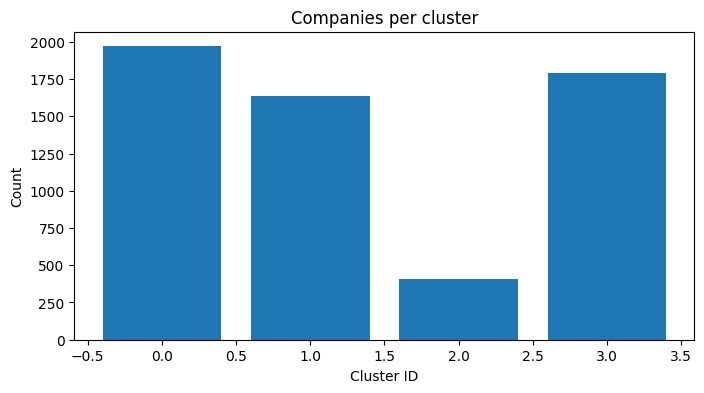

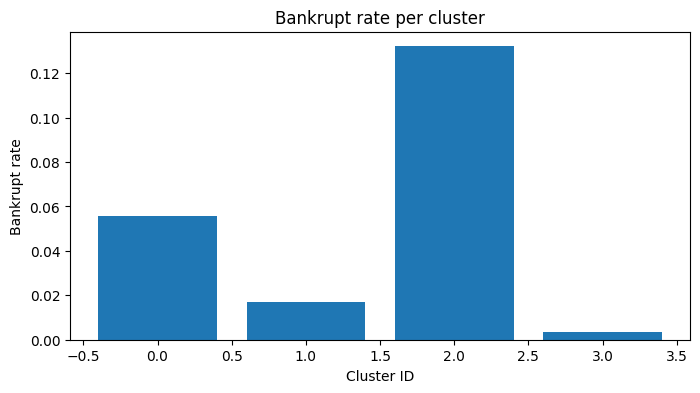

[PosixPath('artifacts/cluster_0_train.csv'),
 PosixPath('artifacts/cluster_1_train.csv'),
 PosixPath('artifacts/cluster_2_train.csv'),
 PosixPath('artifacts/cluster_3_train.csv')]

In [7]:
# Summary statistics per cluster
cluster_table = []
for cid in range(BEST_K):
    mask = labels == cid
    n = int(mask.sum())
    b = int(y_train[mask].sum())
    cluster_table.append({
        "cluster_id": cid,
        "n_companies": n,
        "n_bankrupt": b,
        "bankrupt_rate": b / n if n else 0.0
    })

cluster_stats = pd.DataFrame(cluster_table).sort_values("cluster_id")
print(cluster_stats)

# Simple visualizations (optional but helpful)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(cluster_stats["cluster_id"], cluster_stats["n_companies"])
ax.set_title("Companies per cluster")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Count")
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(cluster_stats["cluster_id"], cluster_stats["bankrupt_rate"])
ax.set_title("Bankrupt rate per cluster")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Bankrupt rate")
plt.show()

# ---- Save one CSV per cluster for teammates ----
cluster_csv_paths = []
for cid in range(BEST_K):
    cluster_df = train_df[train_df["cluster_id"] == cid].copy()
    out_path = ARTIFACT_DIR / f"cluster_{cid}_train.csv"
    cluster_df.to_csv(out_path, index=False)
    cluster_csv_paths.append(out_path)

cluster_csv_paths


## Subgroup Classifier

In [8]:
# Prepare data for cluster ID classifier
X = core_preprocess.transform(train_df.drop(columns=[TARGET_COL, INDEX_COL, 'cluster_id']))
y = train_df['cluster_id'].to_numpy()


Training Gradient Boosting Classifier...
Top 10 most important features for cluster ID prediction:
                                      Feature_Name  Importance
                Degree of Financial Leverage (DFL)    0.076127
Interest Coverage Ratio (Interest expense to EBIT)    0.064759
                              Total Asset Turnover    0.063250
                 Retained Earnings to Total Assets    0.040532
                         Inventory/Working Capital    0.029509
                        Revenue Per Share (Yuan ¥)    0.028442
                            Operating Expense Rate    0.027854
                     Current Liabilities/Liability    0.027226
                              Total expense/Assets    0.023523
                                      Tax rate (A)    0.023092


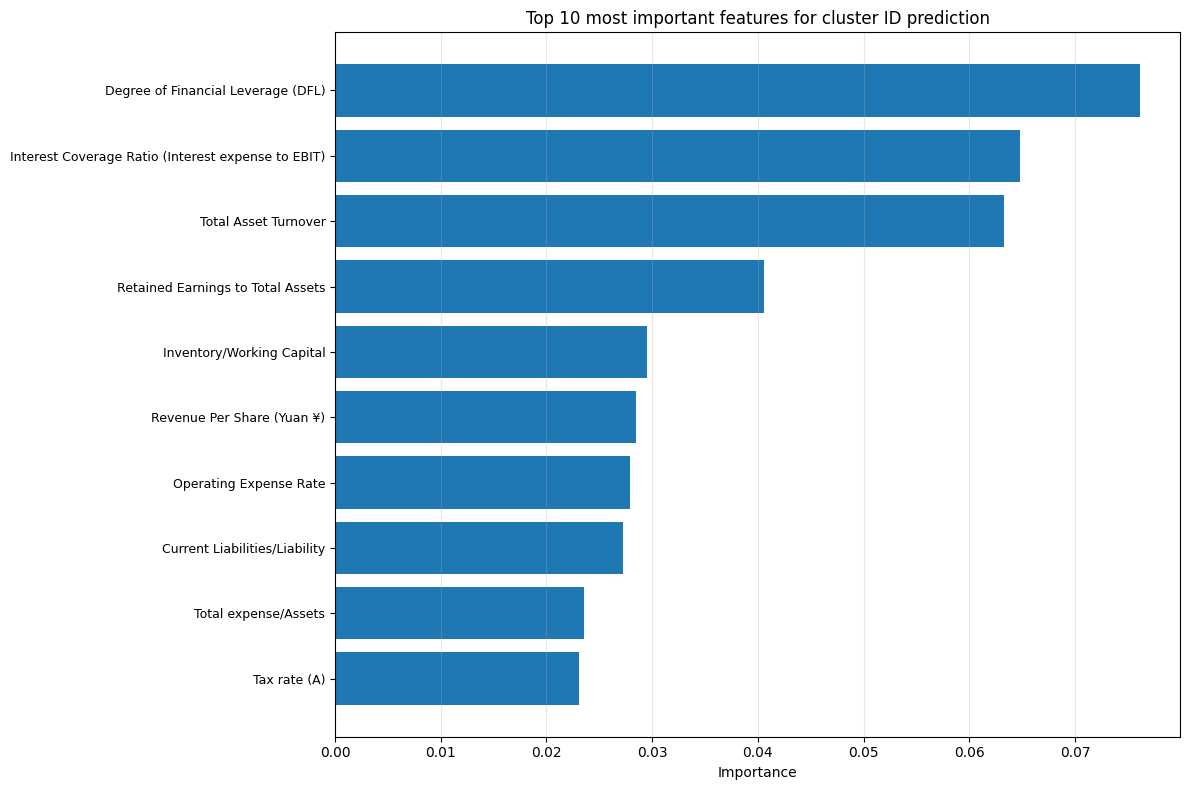


Number of features needed for 90% of total importance: 51
Number of features needed for 95% of total importance: 60
Total number of features: 77


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# Train the Gradient Boosting Classifier on full dataset
print("\nTraining Gradient Boosting Classifier...")
gbclf = GradientBoostingClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)
gbclf.fit(X, y)

# Get feature importances
feature_importances = gbclf.feature_importances_

# Extract feature names from the preprocessing pipeline (after they don't change anymore)
feature_names = core_preprocess.named_steps['skew'].get_feature_names_out()

n_features = len(feature_names)

# Create feature importance dataframe with actual feature names
importance_df = pd.DataFrame({
    'Feature_Name': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("Top 10 most important features for cluster ID prediction:")
print(importance_df.head(10).to_string(index=False))

# Visualize top 10 feature importances
fig, ax = plt.subplots(figsize=(12, 8))
top_10 = importance_df.head(10)
ax.barh(range(10), top_10['Importance'].values[::-1])
ax.set_yticks(range(10))
ax.set_yticklabels(top_10['Feature_Name'].values[::-1], fontsize=9)
ax.set_xlabel('Importance')
ax.set_title("Top 10 most important features for cluster ID prediction")
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate cumulative importance
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
n_features_90 = (importance_df['Cumulative_Importance'] <= 0.90).sum()
n_features_95 = (importance_df['Cumulative_Importance'] <= 0.95).sum()

print(f"\nNumber of features needed for 90% of total importance: {n_features_90}")
print(f"Number of features needed for 95% of total importance: {n_features_95}")
print(f"Total number of features: {n_features}")

In [ ]:
# Save the  classifier
cluster_id_classifier_path = ARTIFACT_DIR / "cluster_id_classifier.joblib"
dump(gbclf, cluster_id_classifier_path)
print(f"\nSaved classifier (Gradient Boosting) to: {cluster_id_classifier_path}")

# Create a summary
print("\nFinal Model:")
print(f"Number of features: {n_features}")
print(f"Top 3 most important features:")
for i in range(3):
    print(f"  {i+1}. {importance_df.iloc[i]['Feature_Name']}: {importance_df.iloc[i]['Importance']:.4f}")


Saved best classifier (Gradient Boosting) to: artifacts/cluster_id_classifier.joblib

Final Model:
Number of features: 77
Top 3 most important features:
  1. Degree of Financial Leverage (DFL): 0.0761
  2. Interest Coverage Ratio (Interest expense to EBIT): 0.0648
  3. Total Asset Turnover: 0.0632
